# Calculate the correlation between mean framewise displacement (mFD) and functional brain connectivity (FC):
## Compare the performance of several pre-processing pipelines in terms of motion correction

### FD - check https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3254728/
### mFD-FC - check https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0173289 and https://www.sciencedirect.com/science/article/pii/S1053811917310972

In [ ]:
# Import all of the necessary modules and libraries

import glob
import os
#import re

import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import statannot
from statannot import add_stat_annotation

import itertools

import nibabel as nib
from nilearn import image
from nilearn import plotting
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

from sklearn.preprocessing import StandardScaler


In [ ]:
# Import atlas with ROIs to be used for the connectivity analysis

# the MSDL (multi-subject dictionary learning; {cite}Varoquaux_2011) atlas defines a set of probabilistic ROIs across the brain.
# import a different atlas, if you prefer
#msdl_atlas = datasets.fetch_atlas_msdl()
#msdl_coords = msdl_atlas.region_coords
#n_regions = len(msdl_coords)
#print(f'MSDL has {n_regions} ROIs, part of the following networks :\n{np.unique(msdl_atlas.networks)}.')

# A non-probabilistic atlas (in the sense that it doesn't learn from your own data):
# check https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases
harv_oxf_atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
rois = harv_oxf_atlas.labels
n_regions = len(rois)
print(f'This atlas has {n_regions} ROIs.')

In [ ]:
# View the atlas
# plotting.plot_prob_atlas(msdl_atlas.maps)
plotting.plot_roi(harv_oxf_atlas.maps)

In [ ]:
# Initiate a masker object to use later for extraction of timeseries from each brain

# Apply a NiftiMapsMasker as the MSDL atlas is probabilistic
# !! if you're using a deterministic atlas, then use a NiftiLabelsMasker object !!

#masker = input_data.NiftiMapsMasker(
#    msdl_atlas.maps, resampling_target="data",
#    t_r=2, detrend=True,
#    low_pass=0.1, high_pass=0.01).fit()

masker = NiftiLabelsMasker(
    harv_oxf_atlas.maps, resampling_target="data",
    t_r=2.5, detrend=True,
    low_pass=0.1, high_pass=0.01).fit()

In [ ]:
# Check the names of all pre-processing pipelines
pipeline_list = sorted(glob.glob("/Volumes/Seagate Dr/PhD/De-noising/*"))
print(*pipeline_list, sep='\n')
print(type(pipeline_list))

In [ ]:
# Inspect contents of each folder
def quality_check(pipeline_list):
    for n in range(len(pipeline_list)):
        current_pipeline = pipeline_list[n]
        print(current_pipeline)
        fmri_img_path = os.path.join(current_pipeline, "*.gz")
        print(fmri_img_path)
        fmri_img = sorted(glob.glob(fmri_img_path))
        print(*fmri_img, sep='\n')
        # check the dimensions of a single participant fMRI data to see if it makes sense!
        fmri_img_single = nib.load(fmri_img[0])
        print(fmri_img_single.shape)

In [ ]:
quality_check(pipeline_list)

In [ ]:
# Calculate the connectivity matrices and the mean functional connectivity (mFC) values (across the brain) for all participants

def calc_conn_mFC(pipeline_list):
    # choose a pipeline
    for p in range(len(pipeline_list)):
        current_pipeline = pipeline_list[p]
        print("Current pipeline:", current_pipeline)
        #set the list of fMRI files
        fmri_img_path = os.path.join(current_pipeline, "*.gz")
        print(fmri_img_path)
        fmri_img = sorted(glob.glob(fmri_img_path))
        # initiate an empty list that will contain a single mFC value for each participant
        mFC_list = []
        # specify for the number of participants you have
        for n in range(len(fmri_img)):
            # check if this is the right participant
            print("Working on participant:")
            print(fmri_img[n])
            # !!!!!! change this line to get your data !!!!!!!
            # !! it is recommended to remove confounds by using the confounds= option and selecting them from your confounds file
            # it is also a good idea to compare the corrected and uncorrected connectivity matrices
            roi_time_series = masker.transform(fmri_img[n])        
            # calculate a connectivity matrix
            # choose a type of correlation analysis, tangent space embedding is recommended, but it requires that the program is run on all subjects simultaneously
            correlation_measure = ConnectivityMeasure(kind='correlation')
            correlation_matrix = correlation_measure.fit_transform([roi_time_series])[0]
            print("Connectivity matrix calculated.")
            # save the matrix to a csv file, using subject n
            # N.B. matrix file will not have column and row names, i.e. the brain region names. 
            # They have to be added from the atlas that was used for the connectivity analysis when doing the plotting (for instance)
            np.savetxt('pipeline'+str(p)+'sub_'+str(n)+'_conn_matrix.csv', correlation_matrix, delimiter=',')
            print('Connectivity matrix for sub'+str(n)+' saved.')
            # calculate mFC and append value to the mFC_list
            mFC = mean(correlation_matrix)
            mFC_list.append(mFC)
            print('mFC_list updated.')
        print('Pipeline'+str(p)+' Analysis Completed.')
        mFC_list = np.array(mFC_list)
        np.savetxt('mFC_list_pipeline'+str(p)+'.csv', mFC_list, delimiter=',')
        print('mFC_list_pipeline'+str(p)+'.csv saved.')
    print("Done.")


In [ ]:
#Run the FC function
calc_conn_mFC(pipeline_list)

In [ ]:
## OPTIONAL ##
# Import a specific correlation matrix and plot it
def load_plot_matrix(csv_matrix):
    conn_matrix = pd.read_csv(csv_matrix, delimiter=',', header=None)
    correlation_matrix = conn_matrix.to_numpy()
    np.fill_diagonal(correlation_matrix, 0)
    plotting.plot_matrix(correlation_matrix, 
                         # omit the first label as that is the "background" ROI, which wasn't actually used !
                         labels=harv_oxf_atlas.labels[1:],
                         vmax=0.8, vmin=-0.8, colorbar=True)

In [ ]:
load_plot_matrix('/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/pipeline0sub_0_conn_matrix.csv')

In [ ]:
# Or view it as an embedded connectome:
#plotting.view_connectome(correlation_matrix, edge_threshold=0.2,
#                         node_coords=msdl_atlas.region_coords)

In [ ]:
# Visually inspect contents of each folder in the Framewise Displacement directory
pipeline_list_FD = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/FD/*"))
print(*pipeline_list_FD, sep='\n')
print(type(pipeline_list))

In [ ]:
# Calculate mean framewise displacement
def calc_mFD(pipeline_list):
    # choose a pipeline
    for p in range(len(pipeline_list)):
        current_pipeline = pipeline_list[p]
        print("Current pipeline:", current_pipeline)
        #set the list of FD files
        FD_path = os.path.join(current_pipeline, "*.txt")
        print(FD_path)
        FD_files = sorted(glob.glob(FD_path))
        # initiate an empty list that will contain a single mFD value for each participant
        mFD_list = []
        # specify for the number of participants you have
        for n in range(len(FD_files)):
            # check if this is the right participant
            print("Working on participant:")
            print(FD_files[n])
            FD = pd.read_table(FD_files[n])
            print("This is the FD data:")
            print(FD)
            # calculate mFD and append value to the mFD_list
            mFD = mean(FD)
            print("mFD =",mFD)
            mFD_list.append(mFD)
            print("mFD list updated.")
        print('Pipeline'+str(p)+' Analysis Completed.')
        mFD_list = np.array(mFD_list)
        np.savetxt('mFD_list_pipeline'+str(p)+'.csv', mFD_list, delimiter=',')
        print('mFD_list_pipeline'+str(p)+'.csv saved.')
    print("Done.")

In [ ]:
# Run the mFD function
calc_mFD(pipeline_list_FD)

In [ ]:
# Get pipeline names

#xls = pd.read_excel(
#     '/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/ARB_QC.xlsx', header=None, sheet_name=None,
#     engine='openpyxl',
#)
#pipeline_names = list(xls.keys())
#pipeline_names

pipeline_names = [
 '1-echo baseline',
 '1-echo + SDC',
 '3-echo',
 '3-echo + SDC',
 '3-echo + T2s',
 '3-echo + T2s + SDC',
 '4-echo',
 '4-echo + SDC',
 '4-echo + T2s',
 '4-echo + T2s + SDC',
'3-echo ME-ICA', 
 '4-echo ME-ICA']

In [ ]:
# Generate a list of all FC csv files (12 pipelines with 17 subjects each, i.e. 12*17 = 204 files)
fconn_list_complete = []
for n in range(12):
    fconn_list_s = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/pipeline"+str(n)+"sub_?_conn_matrix.csv"))
    fconn_list_ss = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/pipeline"+str(n)+"sub_??_conn_matrix.csv"))
    fconn_list_temp = []
    for n in range(len(fconn_list_s)):
        fconn_list_temp.append(fconn_list_s[n])
    for n in range(len(fconn_list_ss)):
        fconn_list_temp.append(fconn_list_ss[n])
    fconn_list_complete.append(fconn_list_temp)
fconn_list_complete

In [ ]:
# Generate a list of all mFD csv files (12 pipelines, i.e. 12 files)
mFdisp_list = []
d_vals = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/mFD_list_pipeline?.csv"))
dd_vals = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/mFD_list_pipeline??.csv"))
for n in range(len(d_vals)):
    mFdisp_list.append(d_vals[n])
for n in range(len(dd_vals)):
    mFdisp_list.append(dd_vals[n])
mFdisp_list

In [ ]:
# Calculate the correlation between functional connectivity and mean framewise displacement
def calc_FC_mFD(fconn_list_complete):
    
    # For each pipeline
    for p in range(len(fconn_list_complete)):
        # Initiate an empty matrix that would be filled with correlation values, i.e. mFD-FC values
        corr_matrix = pd.DataFrame(#index=range(0,1),
        columns=range(0,48))

        # Get the matrices for that pipeline
        fconn_list = fconn_list_complete[p]
        conn_rows = 48
        conn_cols = 48
        # Loop through a specific edge (given by i and j)
        for i in range(conn_rows):
            temp_corr_list = []
            for j in range(conn_cols):
                temp_fc_vals = []
                
                # Loop through subjects
                for n in range(len(fconn_list)):
                    # !! CHECK IF THE SUBJECT ORDER IS CORRECT !!
                    #print("This is participant:" + fconn_list[n])
                    # Load subject connectivity matrix
                    temp_conn_matrix = pd.read_csv(fconn_list[n], delimiter=',', header=None) 
                    # Get the relevant edge value
                    edge = temp_conn_matrix.iloc[i,j]
                    # Add value to list
                    # N.B. Currently including all corr values, though customary to include only r > 0.25
                    #if edge > 0.25:
                        #temp_fc_vals.append(edge)
                    #else:
                        # what should I append
                        #temp_fc_vals.append(0)
                    temp_fc_vals.append(edge)
                    #print("FC value appended.")
                
                # Convert complete particiapnt list for that edge to an array, reshape and check dimensions
                temp_fc_vals = np.array(temp_fc_vals).reshape(17, 1).T
                #print(temp_fc_vals)
                #print(temp_fc_vals.shape)
                
                # Load FD values and check array shape
                fd_pipe = pd.read_csv(mFdisp_list[p], delimiter=' ', header=None)
                fd_pipe = np.array(fd_pipe)
                fd_pipe = fd_pipe.T
                #print(fd_pipe.shape)
                
                # Do correlation between temporary FC values and mFD values for current pipeline
                # N.B. Assumptions for Pearson Correlation are not necessarily met for each pair of values...
                r = np.corrcoef(temp_fc_vals, fd_pipe)
                # Get only the actual r value, not the whole matrix
                #print("r value is:")
                #print(r[0,1])
                # Append to corr_list
                temp_corr_list.append(r[0,1])
                #print("temp_corr_list updated.")
            # Append the whole temp_corr_list as the ith row in the corr_matrix (with values for all j's)
            corr_matrix.loc[len(corr_matrix)] = temp_corr_list
            #print("corr_matrix updated.")
        # Save the entire mFD-FC matrix for that pipeline   
        np.savetxt('mfd-fc_pipeline'+str(p)+'_matrix.csv', corr_matrix, delimiter=',')
        print('mfd-fc_pipeline'+str(p)+'_matrix.csv saved.')
        print("Pipeline" + str(p) + " analysis completed.")
    print("Done.")
    
    
## Super crude... optimise it!!!

In [ ]:
#%%timeit
calc_FC_mFD(fconn_list_complete)

In [ ]:
## OPTIONAL
# Load a single mFD-FC matrix
load_plot_matrix('/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/mfd-fc_pipeline0_matrix.csv')

In [ ]:
# Generate a list of all mFD-FC matrix csv files
pipeline_src_s = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/mfd-fc_pipeline?_matrix.csv"))
pipeline_src_ss = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/mfd-fc_pipeline??_matrix.csv"))

pipeline_list_temp = []
pipeline_list = []

for n in range(len(pipeline_src_s)):
    pipeline_list_temp.append(pipeline_src_s[n])
for n in range(len(pipeline_src_ss)):
    pipeline_list_temp.append(pipeline_src_ss[n])
pipeline_list.append(pipeline_list_temp)
pipeline_list

In [ ]:
# Plot matrices side by side to compare (and to include in supplementary section)
pipeline_list = np.array(pipeline_list)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(50,25))
fig.subplots_adjust(hspace=0.5, wspace=2.5)
fig.suptitle('mFD-FC Comparison')

for i, ax in enumerate(axes.flatten()):
#for i in range(pipeline_list.shape[1]):
    corr_matrix = pd.read_csv(pipeline_list[0][i], delimiter=',', header=None)
    correlation_matrix = corr_matrix.to_numpy()
    np.fill_diagonal(correlation_matrix, 0)
    display = plotting.plot_matrix(correlation_matrix, 
                         # omit the first label as that is the "background" ROI, which wasn't actually used !
                         labels=harv_oxf_atlas.labels[1:],
                         vmax=1, vmin=-1, colorbar=True
                         , axes=ax
                        )
    ax.title.set_text(pipeline_names[i])
    # !!!!! increase the size of each separate subplot !!!!!!
plt.savefig('mFD-FC_set_of_matrices.png')

In [ ]:
# Generate a list of all mFD-FC matrices (as Pandas DataFrames)
# Generate summary statistics
def get_list_of_flat_mfd_fc_and_summarise(pipeline_list):
    corr_matrix_list = []

    results = {'count': [],
    'mean': [],
    'std': [],
    'min': [],
    '25%': [],
    '50%': [],
    '75%': [],
    'max': []}

    # Loop through each pipeline
    for i in range(len(pipeline_list[0])):
        # Load mFD-FC matrix
        corr_matrix = pd.read_csv(pipeline_list[0][i], delimiter=',', header=None)
        # Get mean value for each brain region
        corr_matrix_mean = corr_matrix.mean()
    
        # Append to the list
        corr_matrix_list.append(corr_matrix_mean)
        
        # Generate summary statistics
        sum_stats = corr_matrix.describe()
        #print(type(sum_stats))
        #print(sum_stats.shape)
        #print(sum_stats)
        # Add the summary statistics to the results list
        results['count'].append(sum_stats.loc['count'][0])
        results['mean'].append(sum_stats.loc['mean'][0])
        results['std'].append(sum_stats.loc['std'][0])
        results['min'].append(sum_stats.loc['min'][0])
        results['25%'].append(sum_stats.loc['25%'][0])
        results['50%'].append(sum_stats.loc['50%'][0])
        results['75%'].append(sum_stats.loc['75%'][0])
        results['max'].append(sum_stats.loc['max'][0])
    # Convert results dictionary to DataFrame 
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df.columns = pipeline_names

    return corr_matrix_list, results_df

In [ ]:
corr_matrix_list, results_df = get_list_of_flat_mfd_fc_and_summarise(pipeline_list)
# Show summary statistics
results_df

In [ ]:
# Test for significant differences between the pipelines

In [ ]:
# Create a Pandas DataFrame from the list of flattened mFD-FC matrices
mFD_FC_pipeline_df = pd.concat(corr_matrix_list, axis=1)
# Add the pipeline names
mFD_FC_pipeline_df.columns = pipeline_names

In [ ]:
mFD_FC_pipeline_df.median()

In [ ]:
# Create a list that contains all possible pairs of pipelines WITHOUT repetitions
combo_list = list(itertools.combinations(pipeline_names, 2))
print(combo_list)
# to see how many comparisons would be made:
print(len(combo_list))

In [ ]:
# Use Mann-Whitney test to obtain p-values and correct them using FDR
def mannwhitneyu_fdr(combo_list):
    uncorrected_p_vals = []
    # For each combo
    for n in range(len(combo_list)):
        combo_cont1 = combo_list[n][0]
        combo_cont2 = combo_list[n][1]
        # Perform Mann-Whitney test 
        w, p = mannwhitneyu(mFD_FC_pipeline_df.loc[:, combo_cont1].dropna(), mFD_FC_pipeline_df.loc[:, combo_cont2].dropna())
        uncorrected_p_vals.append(p)
    
    # Correct the p-values using the FDR method
    # and more specifically, one of the newer variations (https://www.jstor.org/stable/20441303?seq=1)
    corrected_p_vals_extra = multipletests(uncorrected_p_vals, alpha=0.05, method='fdr_tsbky')
    corrected_p_vals = corrected_p_vals_extra[1]
    return uncorrected_p_vals, corrected_p_vals

In [ ]:
uncorrected_p_vals, corrected_p_vals = mannwhitneyu_fdr(combo_list)

In [ ]:
print("Values lower than 0.05 =", corrected_p_vals[corrected_p_vals < 0.05])
print("Their indices are ", np.nonzero(corrected_p_vals < 0.05))

In [ ]:
print("Values higher than 0.05 =", corrected_p_vals[corrected_p_vals > 0.05])
print("Their indices are ", np.nonzero(corrected_p_vals > 0.05))

In [ ]:
ns_list = list(np.nonzero(corrected_p_vals > 0.05))

In [ ]:
# Create a mFD-FC boxplot with all pipelines

plt.rcParams["axes.labelsize"] += 23


# create the boxplot using seaborn instead of matplotlib
fig, ax = plt.subplots(figsize=(37,27))
sns.set(font_scale = 2)
ax.tick_params(axis='both', which='both', labelsize=20)

ax.xaxis.set_ticks([ind for ind in range(1, 13)])
ax.set_xticklabels(pipeline_names, rotation=60, fontsize=35)
ax.xaxis.labelpad = 20
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})

ax.yaxis.set_ticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels(['-0.2', '0', '0.2', '0.4', '0.6', '0.8'], rotation=0, fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', 
             #facecolor='wheat', 
             alpha=0.5)

sb_ax = sns.boxplot(data=mFD_FC_pipeline_df, #corr_matrix_list, 
                    order=pipeline_names, 
                    showfliers=False).set(
    xlabel='Pipelines', 
    ylabel='Correlation'
)

# plot with annotations
test_results = add_stat_annotation(ax, data=mFD_FC_pipeline_df, order=pipeline_names,
                                   box_pairs=[combo_list[i] for i in ns_list[0]],
                                   perform_stat_test=False, pvalues=[corrected_p_vals[i] for i in ns_list[0]],
                                   text_format='simple',
                                   loc='inside', 
                                   verbose=2)

#plt.title('mFD-FC scores')
ax.set_title('mFD-FC Scores for the Pre-processing Pipelines',fontsize= 56, fontweight="bold")

# plt.show()
plt.savefig('mFD-FC.png')

In [ ]:
# Fisher R-to-Z transform (to compare to the values from Dipasquale et al., 2017)
def fisher_r_to_z(pipeline_list):
    fisher_z_corr_list = []
    
    for i in range(len(pipeline_list[0])):
        corr_matrix = pd.read_csv(pipeline_list[0][i], delimiter=',', header=None)
        corr_matrix = corr_matrix.to_numpy()
        np.fill_diagonal(corr_matrix, 0)
        #corr_matrix[corr_matrix < 0.25] = 0
        corr_matrix_scaled = np.arctanh(corr_matrix)
        corr_matrix_scaled_df = pd.DataFrame(corr_matrix_scaled)
        # Flatten into 1D vector
        corr_matrix_flat = corr_matrix_scaled_df.values.ravel()
        # Convert and append to the list
        corr_matrix_flat_df = pd.DataFrame(corr_matrix_flat)
        fisher_z_corr_list.append(corr_matrix_flat_df)
        
    # Create a Pandas DataFrame from the list of flattened mFD-FC matrices
    fisher_Z_mFD_FC_pipeline_df = pd.concat(fisher_z_corr_list, axis=1)
    # Add the pipeline names
    fisher_Z_mFD_FC_pipeline_df.columns = pipeline_names
    
    return fisher_Z_mFD_FC_pipeline_df

In [ ]:
fisher_Z_mFD_FC_pipeline_df = fisher_r_to_z(pipeline_list)

In [ ]:
fisher_Z_mFD_FC_pipeline_df.min()

In [ ]:
fisher_Z_mFD_FC_pipeline_df.median()

In [ ]:
fisher_Z_mFD_FC_pipeline_df.max()

In [ ]:
# Create a mFD-FC boxplot with all pipelines

plt.rcParams["axes.labelsize"] = 33


# create the boxplot using seaborn instead of matplotlib
fig, ax = plt.subplots(figsize=(37,27))
sns.set(font_scale = 2)
ax.tick_params(axis='both', which='both', labelsize=10)
ax.xaxis.set_ticks([ind for ind in range(1, 13)])
ax.set_xticklabels(pipeline_names, rotation=45, fontsize=25)
#ax.set_yticklabels(['-0.2','0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4'], rotation=0, fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)
ax.xaxis.labelpad = 20

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', 
             #facecolor='wheat', 
             alpha=0.5)

# place a text box in lower right in axes coords
#textstr = 'All inter-pipeline differences are statistically significant.'
#ax.text(0.55, 0.1, textstr, transform=ax.transAxes, fontsize=32,
#        verticalalignment='top', bbox=props)

sb_ax = sns.boxplot(data=fisher_Z_mFD_FC_pipeline_df, #corr_matrix_list, 
                    order=pipeline_names, 
                    showfliers=False).set(
    xlabel='Pipelines', 
    ylabel='Correlation'
)

# plot with corrected p-values 
# CHANGE THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#test_results = add_stat_annotation(sb_ax, data=mFD_FC_pipeline_df, order=pipeline_names,
#                                   box_pairs=[combo_list[n] for n in range(len(combo_list))],
#                                   perform_stat_test=False, pvalues=corrected_p_vals,
#                                   text_format='star',
#                                   loc='outside', verbose=2)

#plt.title('mFD-FC scores')
ax.set_title('mFD-FC scores (Fisher-Z-transformed)',fontsize= 35) # title of plot

# plt.show()
plt.savefig('mFD-FC_Fisher_Z.png')

### Compared to the results by Dipasquale et al., 2019 (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0173289):

#### N.B. Mine have not been thresholded

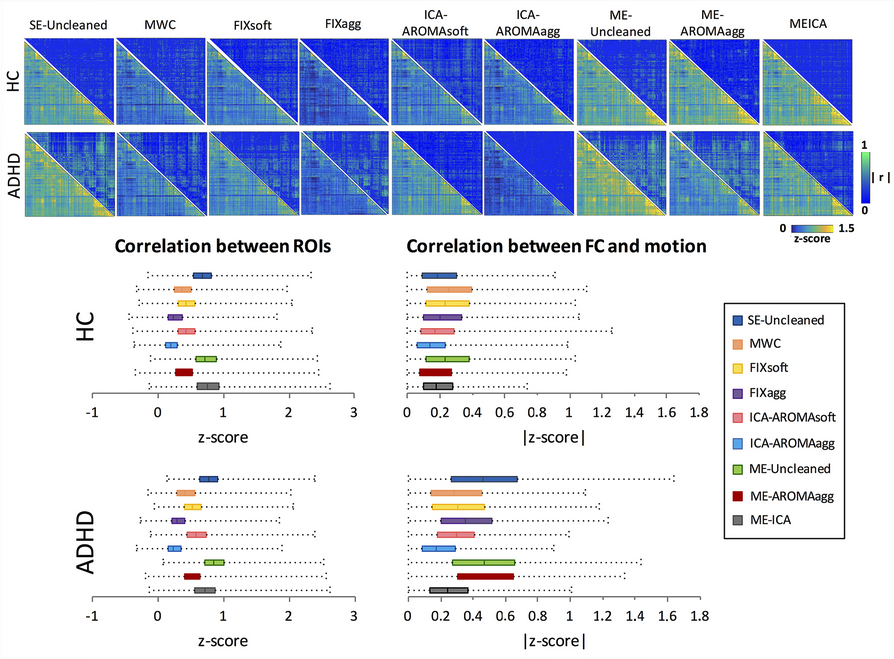